# Diagnosing SQL Server

## <u>Query Store</u>

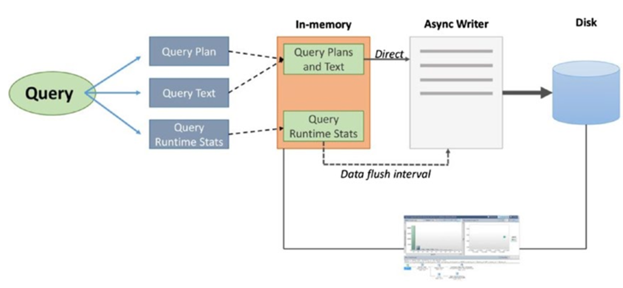

## **<u>Ativar Query Store</u>**

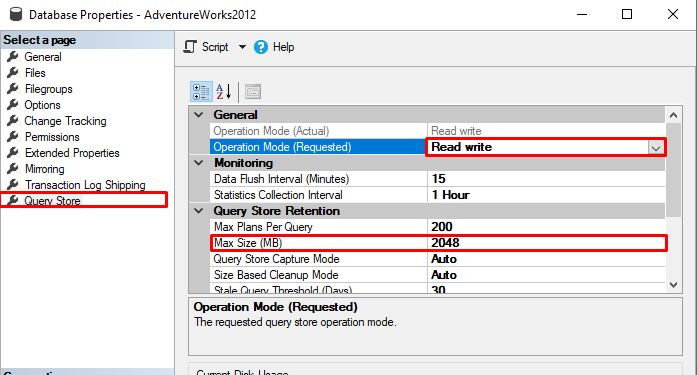

In [ ]:
--Habilitando o QUERY STORE
USE [master]
GO
ALTER DATABASE [StackOverflow2013_SSD] SET QUERY_STORE = ON
GO
ALTER DATABASE [StackOverflow2013_SSD] SET QUERY_STORE (OPERATION_MODE = READ_WRITE)
GO

## <u>Monitorando a performance do banco de dados utilizando o QUERY STORE</u>

In [ ]:
--Últimas consultas executadas no banco de dados
SELECT TOP 10 qt.query_sql_text, q.query_id,
    qt.query_text_id, p.plan_id, rs.last_execution_time
FROM sys.query_store_query_text AS qt
JOIN sys.query_store_query AS q
    ON qt.query_text_id = q.query_text_id
JOIN sys.query_store_plan AS p
    ON q.query_id = p.query_id
JOIN sys.query_store_runtime_stats AS rs
    ON p.plan_id = rs.plan_id
ORDER BY rs.last_execution_time DESC;

In [ ]:

--Número de execuções de cada consulta
SELECT q.query_id, qt.query_text_id, qt.query_sql_text,
    SUM(rs.count_executions) AS total_execution_count
FROM sys.query_store_query_text AS qt
JOIN sys.query_store_query AS q
    ON qt.query_text_id = q.query_text_id
JOIN sys.query_store_plan AS p
    ON q.query_id = p.query_id
JOIN sys.query_store_runtime_stats AS rs
    ON p.plan_id = rs.plan_id
GROUP BY q.query_id, qt.query_text_id, qt.query_sql_text
ORDER BY total_execution_count DESC;

In [ ]:
--Número de consultas com o tempo médio de execução mais longo na última hora
SELECT TOP 10 rs.avg_duration, qt.query_sql_text, q.query_id,
    qt.query_text_id, p.plan_id, GETUTCDATE() AS CurrentUTCTime,
    rs.last_execution_time
FROM sys.query_store_query_text AS qt
JOIN sys.query_store_query AS q
    ON qt.query_text_id = q.query_text_id
JOIN sys.query_store_plan AS p
    ON q.query_id = p.query_id
JOIN sys.query_store_runtime_stats AS rs
    ON p.plan_id = rs.plan_id
WHERE rs.last_execution_time > DATEADD(hour, -1, GETUTCDATE())
ORDER BY rs.avg_duration DESC;

In [ ]:
--Número de consultas que tiveram a maior média de leituras físicas de E/S nas últimas 24 horas, com a média de contagem de linhas e execuções correspondente
SELECT TOP 10 rs.avg_physical_io_reads, qt.query_sql_text,
    q.query_id, qt.query_text_id, p.plan_id, rs.runtime_stats_id,
    rsi.start_time, rsi.end_time, rs.avg_rowcount, rs.count_executions
FROM sys.query_store_query_text AS qt
JOIN sys.query_store_query AS q
    ON qt.query_text_id = q.query_text_id
JOIN sys.query_store_plan AS p
    ON q.query_id = p.query_id
JOIN sys.query_store_runtime_stats AS rs
    ON p.plan_id = rs.plan_id
JOIN sys.query_store_runtime_stats_interval AS rsi
    ON rsi.runtime_stats_interval_id = rs.runtime_stats_interval_id
WHERE rsi.start_time >= DATEADD(hour, -24, GETUTCDATE())
ORDER BY rs.avg_physical_io_reads DESC;

In [ ]:
--Consultas com vários planos de execução
WITH Query_MultPlans
AS
(
SELECT COUNT(*) AS cnt, q.query_id
FROM sys.query_store_query_text AS qt
JOIN sys.query_store_query AS q
    ON qt.query_text_id = q.query_text_id
JOIN sys.query_store_plan AS p
    ON p.query_id = q.query_id
GROUP BY q.query_id
HAVING COUNT(distinct plan_id) > 1
)

SELECT q.query_id, object_name(object_id) AS ContainingObject,
    query_sql_text, plan_id, p.query_plan AS plan_xml,
    p.last_compile_start_time, p.last_execution_time
FROM Query_MultPlans AS qm
JOIN sys.query_store_query AS q
    ON qm.query_id = q.query_id
JOIN sys.query_store_plan AS p
    ON q.query_id = p.query_id
JOIN sys.query_store_query_text qt
    ON qt.query_text_id = q.query_text_id
ORDER BY query_id, plan_id;

In [ ]:
--Consultas com regressão recente de desempenho (comparando diferentes pontos no tempo)
SELECT
    qt.query_sql_text,
    q.query_id,
    qt.query_text_id,
    rs1.runtime_stats_id AS runtime_stats_id_1,
    rsi1.start_time AS interval_1,
    p1.plan_id AS plan_1,
    rs1.avg_duration AS avg_duration_1,
    rs2.avg_duration AS avg_duration_2,
    p2.plan_id AS plan_2,
    rsi2.start_time AS interval_2,
    rs2.runtime_stats_id AS runtime_stats_id_2
FROM sys.query_store_query_text AS qt
JOIN sys.query_store_query AS q
    ON qt.query_text_id = q.query_text_id
JOIN sys.query_store_plan AS p1
    ON q.query_id = p1.query_id
JOIN sys.query_store_runtime_stats AS rs1
    ON p1.plan_id = rs1.plan_id
JOIN sys.query_store_runtime_stats_interval AS rsi1
    ON rsi1.runtime_stats_interval_id = rs1.runtime_stats_interval_id
JOIN sys.query_store_plan AS p2
    ON q.query_id = p2.query_id
JOIN sys.query_store_runtime_stats AS rs2
    ON p2.plan_id = rs2.plan_id
JOIN sys.query_store_runtime_stats_interval AS rsi2
    ON rsi2.runtime_stats_interval_id = rs2.runtime_stats_interval_id
WHERE rsi1.start_time > DATEADD(hour, -48, GETUTCDATE())
    AND rsi2.start_time > rsi1.start_time
    AND p1.plan_id <> p2.plan_id
    AND rs2.avg_duration > 2*rs1.avg_duration
ORDER BY q.query_id, rsi1.start_time, rsi2.start_time;

In [ ]:
--Consultas que estão aguardando mais tempo
SELECT TOP 10
    qt.query_text_id,
    q.query_id,
    p.plan_id,
    sum(total_query_wait_time_ms) AS sum_total_wait_ms
FROM sys.query_store_wait_stats ws
JOIN sys.query_store_plan p ON ws.plan_id = p.plan_id
JOIN sys.query_store_query q ON p.query_id = q.query_id
JOIN sys.query_store_query_text qt ON q.query_text_id = qt.query_text_id
GROUP BY qt.query_text_id, q.query_id, p.plan_id
ORDER BY sum_total_wait_ms DESC

In [ ]:
--Consultas com regressão recente de desempenho (comparando execuções recentes e históricas)
--- "Recent" workload - last 1 hour
DECLARE @recent_start_time datetimeoffset;
DECLARE @recent_end_time datetimeoffset;
SET @recent_start_time = DATEADD(hour, -1, SYSUTCDATETIME());
SET @recent_end_time = SYSUTCDATETIME();

--- "History" workload
DECLARE @history_start_time datetimeoffset;
DECLARE @history_end_time datetimeoffset;
SET @history_start_time = DATEADD(hour, -24, SYSUTCDATETIME());
SET @history_end_time = SYSUTCDATETIME();

WITH
hist AS
(
    SELECT
        p.query_id query_id,
        ROUND(ROUND(CONVERT(FLOAT, SUM(rs.avg_duration * rs.count_executions)) * 0.001, 2), 2) AS total_duration,
        SUM(rs.count_executions) AS count_executions,
        COUNT(distinct p.plan_id) AS num_plans
     FROM sys.query_store_runtime_stats AS rs
        JOIN sys.query_store_plan AS p ON p.plan_id = rs.plan_id
    WHERE (rs.first_execution_time >= @history_start_time
               AND rs.last_execution_time < @history_end_time)
        OR (rs.first_execution_time <= @history_start_time
               AND rs.last_execution_time > @history_start_time)
        OR (rs.first_execution_time <= @history_end_time
               AND rs.last_execution_time > @history_end_time)
    GROUP BY p.query_id
),
recent AS
(
    SELECT
        p.query_id query_id,
        ROUND(ROUND(CONVERT(FLOAT, SUM(rs.avg_duration * rs.count_executions)) * 0.001, 2), 2) AS total_duration,
        SUM(rs.count_executions) AS count_executions,
        COUNT(distinct p.plan_id) AS num_plans
    FROM sys.query_store_runtime_stats AS rs
        JOIN sys.query_store_plan AS p ON p.plan_id = rs.plan_id
    WHERE  (rs.first_execution_time >= @recent_start_time
               AND rs.last_execution_time < @recent_end_time)
        OR (rs.first_execution_time <= @recent_start_time
               AND rs.last_execution_time > @recent_start_time)
        OR (rs.first_execution_time <= @recent_end_time
               AND rs.last_execution_time > @recent_end_time)
    GROUP BY p.query_id
)
SELECT
    results.query_id AS query_id,
    results.query_text AS query_text,
    results.additional_duration_workload AS additional_duration_workload,
    results.total_duration_recent AS total_duration_recent,
    results.total_duration_hist AS total_duration_hist,
    ISNULL(results.count_executions_recent, 0) AS count_executions_recent,
    ISNULL(results.count_executions_hist, 0) AS count_executions_hist
FROM
(
    SELECT
        hist.query_id AS query_id,
        qt.query_sql_text AS query_text,
        ROUND(CONVERT(float, recent.total_duration/
                   recent.count_executions-hist.total_duration/hist.count_executions)
               *(recent.count_executions), 2) AS additional_duration_workload,
        ROUND(recent.total_duration, 2) AS total_duration_recent,
        ROUND(hist.total_duration, 2) AS total_duration_hist,
        recent.count_executions AS count_executions_recent,
        hist.count_executions AS count_executions_hist
    FROM hist
        JOIN recent
            ON hist.query_id = recent.query_id
        JOIN sys.query_store_query AS q
            ON q.query_id = hist.query_id
        JOIN sys.query_store_query_text AS qt
            ON q.query_text_id = qt.query_text_id
) AS results
WHERE additional_duration_workload > 0
ORDER BY additional_duration_workload DESC
OPTION (MERGE JOIN);